In [1]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
tqdm.pandas()


yf.pdr_override()
from pandas_datareader import data as web

In [2]:
#stocks=['AAPL','MSFT','GOOG','AMZN','TSLA','UNH','JNJ','XOM','V']
stocks=['PETR4.SA','VALE3.SA','ABEV3.SA','ITUB4.SA','WEGE3.SA','BBDC3.SA','BPAC11.SA','ELET3.SA','SANB11.SA','BBAS3.SA']

start_date='2016-01-01'
end_date=datetime.now()
df = yf.download(stocks,start=start_date, end=end_date)['Close']
num_ports = 10000
df.head()

[*********************100%***********************]  10 of 10 completed


,ABEV3.SA,BBAS3.SA,BBDC3.SA,BPAC11.SA,ELET3.SA,ITUB4.SA,PETR4.SA,SANB11.SA,VALE3.SA,WEGE3.SA
Date,,,,,,,,,,
2016-01-04,17.209999,14.24,9.501977,NaN,5.427937,15.230303,6.87,14.65,12.69,5.630769
2016-01-05,17.480000,14.29,9.567833,NaN,5.547891,15.357575,6.68,14.43,12.52,5.903846
2016-01-06,17.309999,14.29,9.398490,NaN,5.447929,15.296969,6.40,14.10,11.60,5.769230
2016-01-07,16.850000,13.95,9.097438,NaN,5.178032,15.006060,6.26,13.71,10.91,5.603846
2016-01-08,17.070000,13.95,9.078622,NaN,5.038085,15.012121,6.27,13.71,10.54,5.576923


In [3]:
log_ret = np.log(df/df.shift(1))

all_weights = np.zeros((num_ports, len(df.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in tqdm(range(num_ports),colour="green"):
    # Weights
    weights = np.array(np.random.random(len(df.columns)))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (log_ret.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]
    
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol=vol_arr[sharpe_arr.argmax()]


100%|██████████| 10000/10000 [00:07<00:00, 1413.23it/s]


In [4]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    #return np.sum(np.abs(weights)) - 1
    return np.sum(weights)-1

def minimize_volatility(weigths):
    return get_ret_vol_sr(weigths)[1]

In [5]:
cons = ({'type':'eq','fun':check_sum})

bounds=np.tile([(0,1)],(len(df.columns),1))
init_guess =np.tile(1/len(df.columns),(len(df.columns)))

from scipy.optimize import minimize
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
print(opt_results)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8782617023706084
       x: [ 0.000e+00  0.000e+00  2.012e-16  2.008e-01  6.205e-02
            1.597e-17  0.000e+00  0.000e+00  2.232e-01  5.140e-01]
     nit: 5
     jac: [ 4.751e-01  1.899e-01  4.530e-01  1.723e-04  1.118e-06
            2.713e-01  2.052e-01  2.487e-01  2.860e-04 -1.916e-04]
    nfev: 56
    njev: 5


In [6]:
frontier_y = np.linspace(0,0.3,300)
frontier_x = []
results = []

def minimizer(possible_return):
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    results.append(result)
    frontier_x.append(result['fun'])
                      

In [7]:
start=time.time()
frontier_x=[]

for possible_return in tqdm(frontier_y,colour="green"):
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    results.append(result)
    frontier_x.append(result['fun'])


100%|██████████| 300/300 [01:08<00:00,  4.40it/s]


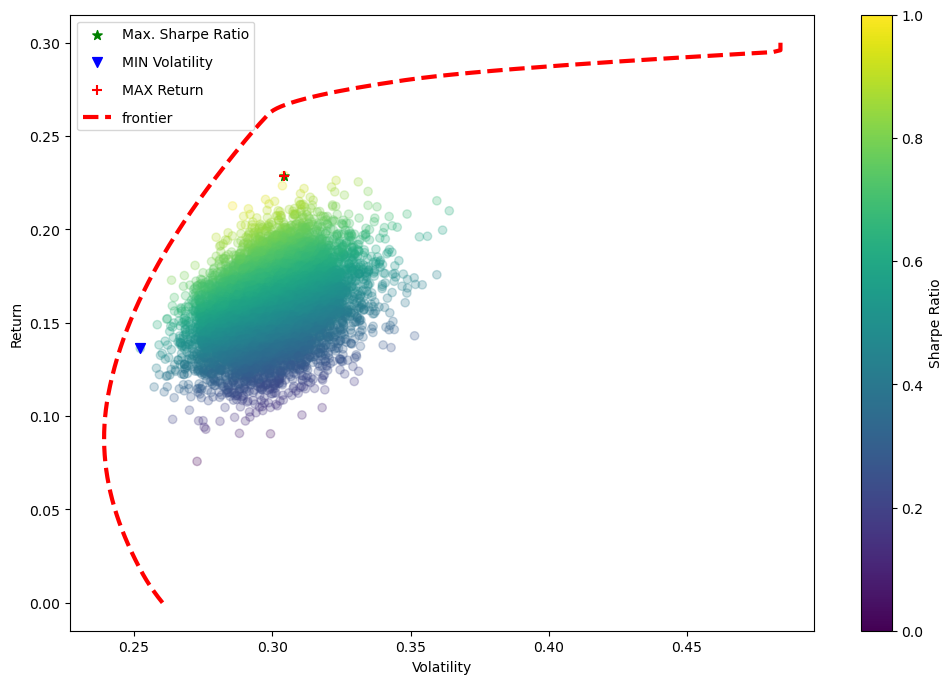

In [8]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis',alpha=0.25)
            
plt.scatter(max_sr_vol, max_sr_ret,c='green',marker='*', s=50,label = "Max. Sharpe Ratio") 
plt.scatter(min(vol_arr),ret_arr[vol_arr.argmin()],c='Blue',marker='v', s=50,label = "MIN Volatility")#erro
plt.scatter(vol_arr[ret_arr.argmax()],max(ret_arr),c='Red',marker='+', s=50,label = "MAX Return")#erro

plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3,label="frontier")       

plt.legend(labelspacing=1, loc='upper left')


plt.show()

In [9]:
print('--------------MAX sharpe ratio--------------\n'
      ,'sharpe ratio :{:.4f}'.format(sharpe_arr.max())
      ,'\t volatility:{:.4f}'.format(vol_arr[sharpe_arr.argmax()])
      ,'\t return:{:.4f}'.format(ret_arr[sharpe_arr.argmax()])
      ,'\n-----Stocks-----'
     )
for i ,j in zip(stocks,all_weights[sharpe_arr.argmax(),:]):
    print(i,':{:.4f}'.format(float(j)))
    

#plt.scatter(min(vol_arr),ret_arr[vol_arr.argmin()],c='Blue',marker='v', s=50,label = "MIN Volatility")#erro
#plt.scatter(vol_arr[ret_arr.argmax()],max(ret_arr),c='Red',marker='+', s=50,label = "MAX Return")#erro
        
print('--------------MIN.Volatility--------------\n'
      ,'sharpe ratio :{:.4f}'.format(float(sharpe_arr[vol_arr.argmin()]))
      ,'\t volatility:{:.4f}'.format(float(min(vol_arr)))
      ,'\t return:{:.4f}'.format(float(ret_arr[vol_arr.argmin()]))
      ,'\n-----Stocks-----'
     )

for i ,j in zip(stocks,all_weights[vol_arr.argmin(),:]):
    print(i,':{:.4f}'.format(float(j)))


print('--------------MAX Return--------------\n'
      ,'sharpe ratio :{:.4f}'.format(float(sharpe_arr[ret_arr.argmax()]))
      ,'\t volatility:{:.4f}'.format(float(vol_arr[ret_arr.argmax()]))
      ,'\t return:{:.4f}'.format(float(max(ret_arr)))
      ,'\n-----Stocks-----'
     )
    
for i ,j in zip(stocks,all_weights[ret_arr.argmax(),:]):
    print(i,':{:.4f}'.format(float(j)))

--------------MAX sharpe ratio--------------
 sharpe ratio :0.7519 	 volatility:0.3044 	 return:0.2289 
-----Stocks-----
PETR4.SA :0.0192
VALE3.SA :0.0084
ABEV3.SA :0.0385
ITUB4.SA :0.3295
WEGE3.SA :0.0383
BBDC3.SA :0.0756
BPAC11.SA :0.0374
ELET3.SA :0.0613
SANB11.SA :0.1220
BBAS3.SA :0.2697
--------------MIN.Volatility--------------
 sharpe ratio :0.5402 	 volatility:0.2523 	 return:0.1363 
-----Stocks-----
PETR4.SA :0.2818
VALE3.SA :0.0454
ABEV3.SA :0.0627
ITUB4.SA :0.0657
WEGE3.SA :0.0303
BBDC3.SA :0.1160
BPAC11.SA :0.0188
ELET3.SA :0.0194
SANB11.SA :0.1249
BBAS3.SA :0.2349
--------------MAX Return--------------
 sharpe ratio :0.7519 	 volatility:0.3044 	 return:0.2289 
-----Stocks-----
PETR4.SA :0.0192
VALE3.SA :0.0084
ABEV3.SA :0.0385
ITUB4.SA :0.3295
WEGE3.SA :0.0383
BBDC3.SA :0.0756
BPAC11.SA :0.0374
ELET3.SA :0.0613
SANB11.SA :0.1220
BBAS3.SA :0.2697
